# Research Experiments on the effect of parent Selection on Generalization for symbolic Regression in GP

## Epsilon Lexicase Selection

* Masterseminar: SoSe 2022
* JGU Mainz
* FB 03 Recht-und Wirtschaftswissenschaften
* Lehrstuhl für Wirtschaftsinformatik und BWL

## Dependencies

In [21]:
import numpy as np
import pandas as pd
import operator
from deap import gp, tools, creator, base, algorithms
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Callable
import math
from random import randint


## Energy efficiency Data Set

Source: https://archive.ics.uci.edu/ml/datasets/energy+efficiency

In [22]:
#(re-)download file to ./data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx -P ./data

--2022-06-26 21:08:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76189 (74K) [application/x-httpd-php]
Saving to: ‘./data/ENB2012_data.xlsx.1’

ENB2012_data.xlsx.1 100%[===================>]  74,40K   235KB/s    in 0,3s    

2022-06-26 21:08:48 (235 KB/s) - ‘./data/ENB2012_data.xlsx.1’ saved [76189/76189]



In [23]:
D_PATH = "data/ENB2012_data.xlsx"

# TODO: research optimal splitsize!
TRAINING_D_SPLITSIZE = 0.5

def get_dataSets(datapath: str, train_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Read (excel) dataset at <datapath> and return two randomly split DFs for training/testing"""
    df = pd.read_excel(datapath)
    return train_test_split(df, train_size=train_size, test_size=(1-train_size))    

trainDF, testDF = get_dataSets(D_PATH, TRAINING_D_SPLITSIZE)

In [24]:
trainDF.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
642,0.79,637.0,343.0,147.0,7.0,4,0.40,3,42.49,38.81
21,0.76,661.5,416.5,122.5,7.0,3,0.00,0,23.93,29.68
514,0.69,735.0,294.0,220.5,3.5,4,0.25,5,12.18,15.22
4,0.90,563.5,318.5,122.5,7.0,2,0.00,0,20.84,28.28
459,0.74,686.0,245.0,220.5,3.5,5,0.25,4,12.43,15.35


In [25]:
trainDF.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,0.763411,672.920573,317.351562,177.784505,5.195312,3.466146,0.235807,2.768229,21.911536,24.152969
std,0.108988,90.184512,41.391181,45.396972,1.751427,1.109607,0.137063,1.529836,10.072073,9.372005
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.050000,11.190000
25%,0.660000,588.000000,294.000000,147.000000,3.500000,2.750000,0.100000,2.000000,12.877500,15.407500
50%,0.740000,686.000000,318.500000,220.500000,3.500000,3.000000,0.250000,3.000000,18.235000,21.330000
75%,0.860000,759.500000,343.000000,220.500000,7.000000,4.000000,0.400000,4.000000,31.247500,32.565000
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,43.100000,46.940000


## Data Visualization

In [26]:
from matplotlib import pyplot as plt
import networkx as nx
import pygraphviz as pgv

%matplotlib inline

def plot_exprTree(expr_tree, title:str) -> None:
    """plots an expression tree"""
    nodes, edges, labels = gp.graph(expr_tree)

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)

    plt.title(title)
    plt.savefig("example_model_elexicase.png")
    plt.show()

## GP System Setup

### Primitive set

In [27]:
UVS = {
    "ARG0" : "X1",
    "ARG1" : "X2",
    "ARG2" : "X3",
    "ARG3" : "X4",
    "ARG4" : "X5",
    "ARG5" : "X6",
    "ARG6" : "X7",
    "ARG7" : "X8",
}

# register the Primitive Set
pset = gp.PrimitiveSet("MAIN", arity=len(UVS))

# rename ARGS to match the dataset
for arg, des in UVS.items():
    pset.renameArguments(arg=des)


In [28]:
# adding functions

def saveDiv(lhs, rhs) -> float:
    """
    GP-save implementation of Division
    [@poli08:fieldguide, p.22]
    """
    if rhs == 0:
        return 1
    return lhs / rhs


operators = (
    (operator.add, 2),
    (operator.sub, 2),
    (operator.mul, 2),
    (saveDiv, 2),
    (math.sin, 1),
    (math.cos, 1),
    # FIXME: (math.exp, 1),
    # FIXME: (math.log, 1),
    (operator.neg, 1)
)

for (func, arity) in operators:
    pset.addPrimitive(func, arity)

pset.addEphemeralConstant("rand1", lambda: randint(-1,1))

Exception: Ephemerals with different functions should be named differently, even between psets.

### Custom Types

In [ ]:
# min fitness object

# objective: minimize MAD for y1

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))


In [ ]:
# individuals program
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

## Algorithmic specifications

In [ ]:
# TODO: research alternatives

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [ ]:
# fitness function for all fitness case:
def evaluate_df_y1_symReg (individual:creator.Individual, df:pd.core.frame.DataFrame) -> tuple[float]:
    """
    Evaluates an individual program for all fitness cases (=rows of pd.dataframe) inside the dataframe, computes and returns the mean absolute error for prediction and outcome for y1 and model prediction
    """
    # Transform the tree expression in a callable function
    compiled_individual = toolbox.compile(expr=individual)

    def evaluate_single_case_y1_symReg(func:Callable, case:pd.core.series.Series) -> float:
        """
        Evaluates an individual, compiled program for a single fitness case (=row of pd.dataframe), computes and returns the absolute error for prediction and outcome for y1 and model prediction
        """
        # compute individual with case variables
        y1_prediction = func(*case[0:8:].values)

        # optimal value:
        y1_value = case[8:9:].values[0]

        # compute absolute difference and return
        abs_error = abs(y1_prediction - y1_value)
        return (abs_error)
    
    n = len(df)
    abs_error_aggregate = 0.0

    # iterate through all fitness cases and aggregate absolute errors
    for _, fitness_case in df.iterrows():
        abs_error_aggregate += evaluate_single_case_y1_symReg(func=compiled_individual, case=fitness_case)
    
    # compute and return MAE
    mean_absolute_error = abs_error_aggregate / n
    return (mean_absolute_error, )


In [ ]:
# GP system setup

toolbox.register("evaluate", evaluate_df_y1_symReg, df=trainDF)

# registration:
toolbox.register("select", tools.selAutomaticEpsilonLexicase)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# decoration:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

## Statistics

In [ ]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [18]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats, halloffame=hof, verbose=True)

   	      	                   fitness                   	                      size                     
   	      	---------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min    	nevals	std  	avg    	gen	max	min	nevals	std    
0  	300   	2780.65	0  	549855	11.4218	300   	33927	3.42333	0  	7  	2  	300   	1.36777
1  	169   	31.5659	1  	962.355	11.4218	169   	112.937	3.12333	1  	9  	1  	169   	0.80919
2  	164   	2253.49	2  	453821 	11.4218	164   	28832.2	3.14667	2  	9  	1  	164   	0.803216
3  	138   	7261.26	3  	2.17356e+06	11.4218	138   	125280 	3.09   	3  	9  	1  	138   	0.639192
4  	171   	26.8319	4  	684.477    	11.4218	171   	88.6483	3.11667	4  	8  	1  	171   	0.618915
5  	176   	208.984	5  	55049      	11.4218	176   	3172.71	3.08333	5  	9  	1  	176   	0.732386
6  	181   	17.2161	6  	645.897    	11.4218	181   	43.4989	3.06   	6  	8  	1  	181   	0.640104
7  	163   	22.2109	7  	684.477    	11.4218	163   	65.0583	3.103

add(add(cos(add(add(add(ARG4, ARG4), add(cos(ARG4), ARG4)), mul(ARG4, ARG6))), ARG4), add(add(add(add(cos(add(add(add(add(add(cos(add(add(add(ARG4, ARG4), add(cos(ARG4), ARG4)), ARG2)), add(sub(saveDiv(ARG3, ARG1), cos(ARG1)), ARG4)), mul(ARG4, ARG6)), ARG4), add(cos(ARG2), ARG4)), mul(ARG4, ARG6))), ARG4), add(cos(add(add(add(ARG4, ARG4), add(cos(ARG4), ARG4)), mul(add(cos(add(add(ARG4, ARG4), mul(ARG4, ARG6))), add(cos(add(add(add(ARG4, ARG4), add(cos(ARG4), ARG4)), ARG2)), add(sub(saveDiv(ARG3, ARG1), cos(ARG1)), ARG4))), ARG6))), ARG4)), add(cos(add(add(add(ARG4, ARG4), add(cos(ARG4), ARG4)), mul(ARG4, neg(ARG3)))), ARG4)), mul(add(cos(add(add(cos(add(add(add(ARG4, ARG4), add(cos(ARG4), ARG4)), ARG2)), add(sub(saveDiv(add(add(add(ARG4, ARG4), add(cos(ARG4), ARG4)), ARG2), ARG1), cos(ARG1)), ARG4)), mul(ARG4, ARG6))), add(cos(ARG4), add(cos(add(add(add(ARG4, ARG4), add(cos(ARG4), ARG4)), mul(add(cos(add(add(ARG4, ARG4), mul(ARG4, ARG6))), add(cos(add(add(add(ARG4, ARG4), add(cos(ARG

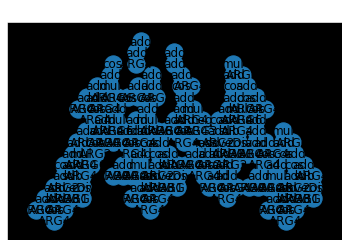

In [19]:

for elite in hof:
    winner = elite
    print (elite)
    plot_exprTree(elite, "Best Solution")

In [20]:
winner_func = gp.compile(winner, pset)

abs_err_agg = 0.0
n = len(testDF)

for _, case in testDF.iterrows():
    abs_err_agg += abs(winner_func(*case[0:8:].values) - case[8:9:].values[0])

MAE = abs_err_agg / n

print("Mean absolute error for unknown Dataset = ", MAE)

Mean absolute error for unknown Dataset =  2.563194287235575
